# MACS1206: Measure metallicity in image plane

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

from scipy import stats
from scipy.stats import binned_statistic
import numpy as np
import glob

from astropy.io import fits
from astropy.wcs import WCS
from astropy import cosmology as co
import astropy.units as uu
from astropy.stats import median_absolute_deviation, sigma_clipped_stats
from astropy.convolution import convolve,Gaussian2DKernel,Moffat2DKernel
from astropy.table import Table
from reproject import reproject_interp

from lmfit import Parameters
import time
import pickle
import emcee
import corner

import warnings
warnings.filterwarnings('ignore')

z = 1.033

## 1) Binning

Base the tesellation on the MUSE data. The lowest flux emission line needed is NII, but it is quite challanging to have a pixel-by-pixel pseudo-narrow band of this line (since it is too faint for gaussian fitting, that's why we are binning!, and the Balmer absoption makes narrow banding the cube hard). Instead we use Halpha. And do it interactivelly :(

In [2]:
from vorbin.voronoi_2d_binning import voronoi_2d_binning

def make_voronoi_tessalation_input(signal,noise,mask=None,out_name='test'):
        p_list      = []
        q_list      = []
        signal_list = []
        noise_list  = []

        if mask is None:
                mask = np.zeros_like(signal)

        for p in range(0,signal.shape[0]):
                for q in range(0,signal.shape[1]):
                        if signal[p,q]>=0 and noise[p,q]>0. and mask[p,q]==1:
                                p_list.append(p)
                                q_list.append(q)
                                signal_list.append(signal[p,q])
                                noise_list.append(noise[p,q])
                        else:
                                continue

        np.savetxt('SNR_'+out_name+'.txt',zip(p_list,q_list,signal_list,noise_list),fmt=('%d %d %0.3e %0.3e'),header = 'p q signal noise')

def voronoi_binning(snr_file,targetSN):

    x, y, signal, noise = np.loadtxt(snr_file,unpack=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, targetSN, plot=True, quiet=True)
    np.savetxt(snr_file.replace('SNR','bins_SN_'+str(targetSN)), np.column_stack([x, y, binNum]),
               fmt=b'%10.6f %10.6f %8i')

<IPython.core.display.Javascript object>


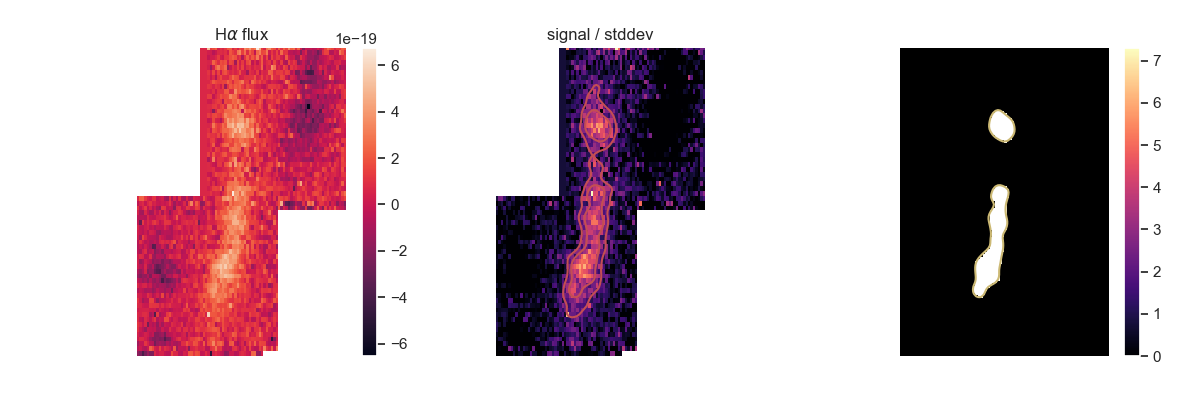

In [3]:
flux = fits.getdata('../../SpectraAnalysis/Image_MACS1206_Ha_flux_corrected.fits') 

# make mask
mean, median, stddev = sigma_clipped_stats(flux[110:,30:55])
smooth_flux = convolve(flux,Gaussian2DKernel(2))
mask = np.zeros_like(flux)
mask[np.where(smooth_flux/stddev> 3)] = 1

# plot some images
fig, ax = plt.subplots(1,3,figsize=(12,4))
fig.subplots_adjust(left=0.05,right=0.95)

ax[0].set_title('H$\\alpha$ flux')
cax = ax[0].imshow(flux,origin='lower')
plt.colorbar(cax,ax=ax[0],fraction=0.05)

snr_map_1 = flux/stddev
snr_map_1_smooth = smooth_flux/stddev
ax[1].set_title('signal / stddev')
cax = ax[1].imshow(snr_map_1,origin='lower',vmin=0,cmap='magma')
plt.colorbar(cax,ax=ax[2],fraction=0.05)
ax[1].contour(snr_map_1_smooth,levels=[2,3],colors='r')

ax[2].imshow(mask,origin='lower',cmap='Greys_r')
ax[2].contour(snr_map_1_smooth,levels=[3],colors='y')

dummy = [x.axis('off') for x in ax]

make_voronoi_tessalation_input(signal=flux,noise=np.ones_like(flux)*stddev,mask=mask, out_name='flux_stddev')

<IPython.core.display.Javascript object>


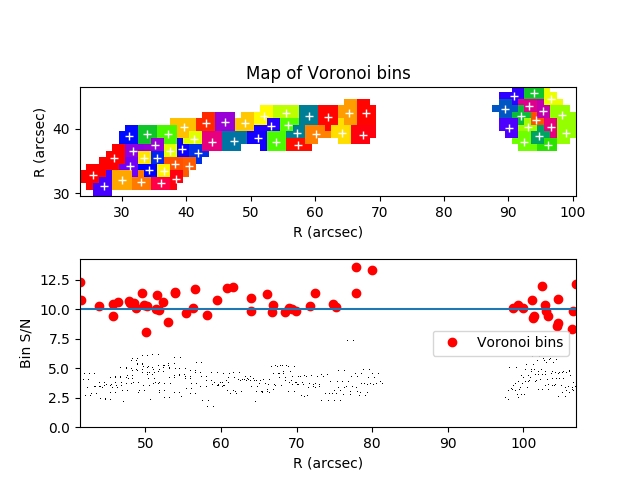

In [28]:
plt.figure()
voronoi_binning('SNR_flux_stddev.txt',10)

Make map, it will be easier to extract

<IPython.core.display.Javascript object>


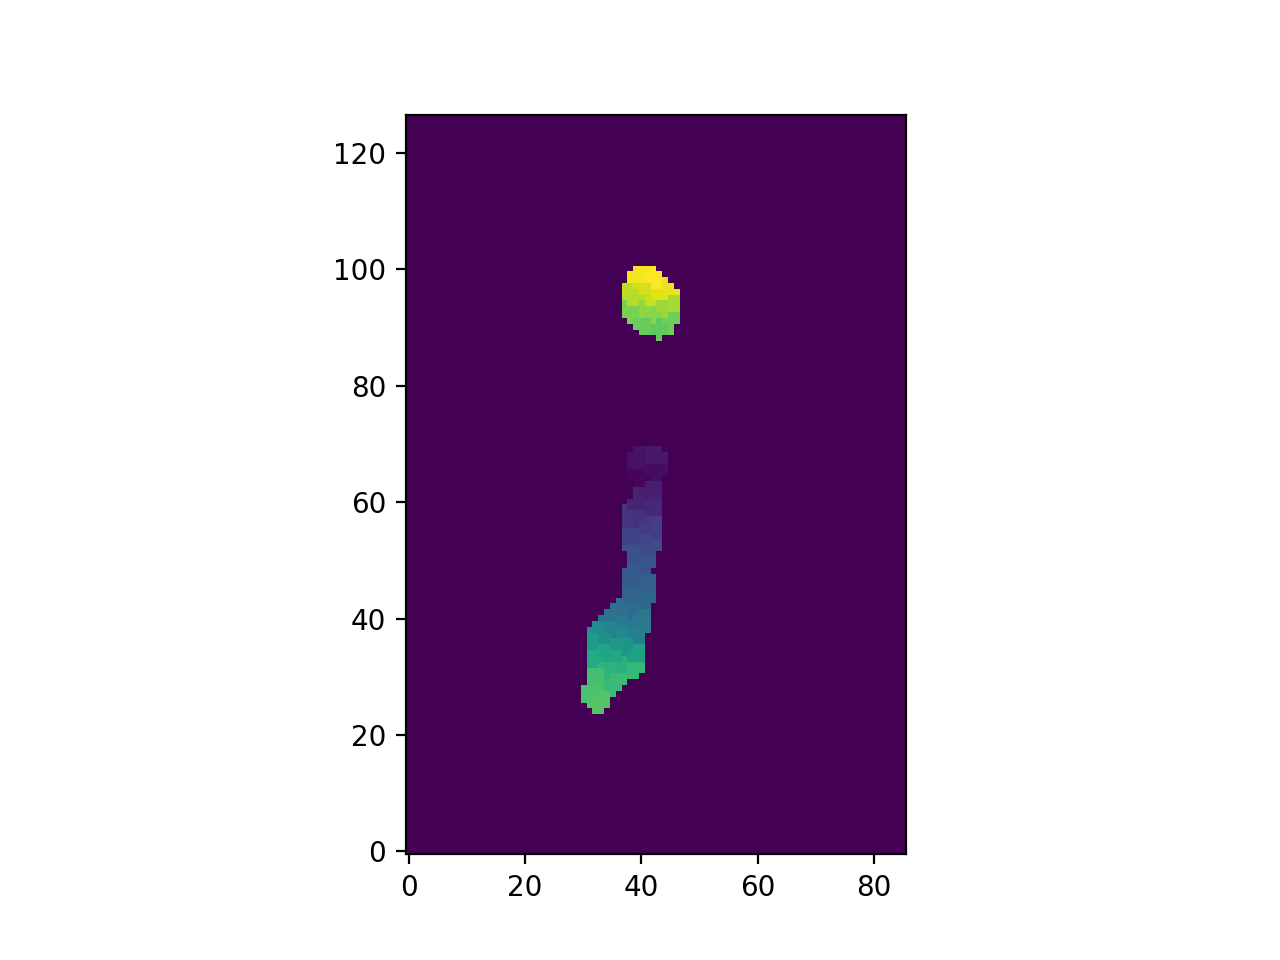

In [4]:
header =  fits.getheader('../../Data/Images/MACS1206/MACS1206_aligned_wcs.fits')
vor_map = np.ones_like(flux)*-1

listp, listq , listbin = np.loadtxt('bins_SN_10_flux_stddev.txt',unpack=True)
for p,q,b in zip(listp,listq,listbin):
    vor_map[int(p),int(q)] = b
    
plt.figure()
plt.imshow(vor_map,origin='lower')
fits.writeto('map_bins_SN_10_flux_stddev.fits',data=vor_map,header=header,overwrite=True)

## 2) Extract spectra 

(the data is quite crappy, no need to worry about continuum!)

In [33]:
cube = fits.getdata('../../Data/Cubes/Cube_SINFONI_MACS1206_sigmaclipped_flux_corrected.fits')
h1= fits.getheader('../../SpectraAnalysis/Spectrum_arc_SINFONI_sinf_apperture.fits')
vor_map = fits.getdata('map_bins_SN_10_flux_stddev.fits')

p, q , listbin = np.loadtxt('bins_SN_10_flux_stddev.txt',unpack=True)

for bin_nb in np.unique(listbin):
    
    idx_map = np.zeros_like(vor_map)
    idx_map[np.where(vor_map == bin_nb)] = 1    
    
    # Extract spectrum
    h1['bin_nb'] = bin_nb
    new_cube = np.zeros_like(cube)
    new_cube[:,:,:] = cube[:,:,:]
    gal_lin = np.nanmean(new_cube*idx_map,axis=(1,2)) / np.mean(idx_map)
    
    fits.writeto('Spectra/Sp_bin_%d.fits'%bin_nb,data=gal_lin,header = h1)

fit with alfa

> python fit_with_alfa.py

print to pdf

<IPython.core.display.Javascript object>


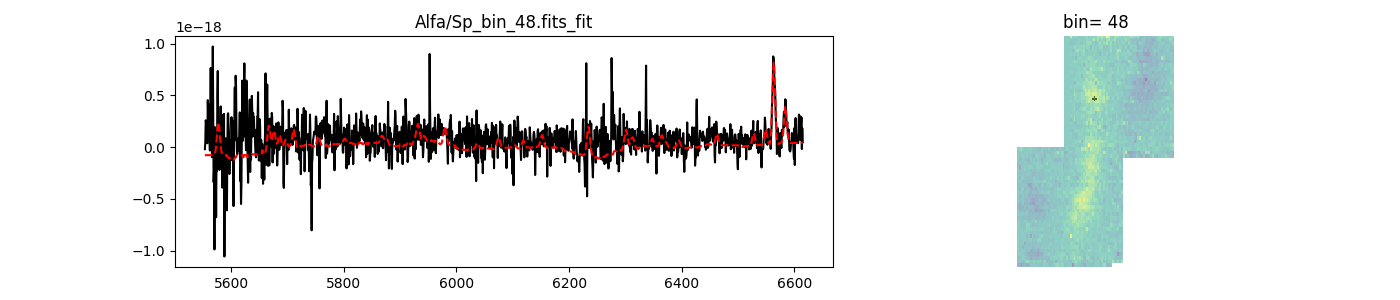

In [35]:
p, q , listbin = np.loadtxt('bins_SN_10_flux_stddev.txt',unpack=True)

fig, ax = plt.subplots(1,2,gridspec_kw={"width_ratios":[2,1]},figsize=(14,3))

for spfile in glob.glob('Alfa/Sp_bin*.fits_fit'):
    
    lbd, sp, fit = np.loadtxt(spfile,usecols=(0,1,2),unpack=True)
    h = fits.getheader(spfile.replace('Alfa/','Spectra/').replace('.fits_fit','.fits'))
    
    idx = np.where(vor_map == h["bin_nb"])
    dummy_im = np.zeros_like(mask) 
    dummy_im[idx] = 1

    #fig.clear()
    ax[0].clear()
    ax[0].plot(lbd,sp,color='k')
    ax[0].plot(lbd,fit,color='r',linestyle='--')
    
    ax[1].clear()
    ax[1].imshow(flux,origin='lower')
    ax[1].imshow(dummy_im,origin='lower',alpha=0.5,cmap='Greys')
    ax[1].axis('off')
    
    ax[0].set_title(spfile)
    ax[1].set_title('bin= %d'%h['bin_nb'])
    
    plt.savefig(spfile.replace('.fits_fit','.pdf'))

Reconstruct the flux maps

In [4]:
def read_fluxes(filename,alfa_name):
    
    lbd, f, err, fwhm  = np.genfromtxt(filename,unpack=True,usecols=(1,2,3,5))
    lbd = list(lbd)
    
    cont = np.genfromtxt(filename.replace('lines','fit'),usecols=(1))
    cont_mean,_, cont_noise = sigma_clipped_stats(cont[1100:1275]) # empty of emission lines
    
    flx = []
    unc = []
    
    for l in [6562.77, 6583.5]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)])
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)

    return flx, unc

def empty_array(array):
    new = np.zeros_like(array)
    new[:,:] = np.nan
    return new

def reconstruct_maps(alfalist,alfa_name,bin_map_name):
        
    bin_map = fits.getdata(bin_map_name)    
        
    Ha_map = empty_array(bin_map)
    NII_map = empty_array(bin_map)
    
    Ha_unc_map = empty_array(bin_map)
    NII_unc_map = empty_array(bin_map)
    
    Ha_snr = empty_array(bin_map)
    NII_snr = empty_array(bin_map)

    unc_ha = []
    unc_nii = []
    flux_ha = []
    flux_nii = []
    bin_nb = []


    for alfafile in alfalist:

        try:
            flux, unc = read_fluxes(alfafile,alfa_name)
        except TypeError:
            print(alfafile)


        # To save in a table  
        bin_nb.append(alfafile.replace(alfa_name,'').replace('.fits_lines',''))
        flux_ha.append(flux[0])
        flux_nii.append(flux[1])
        unc_ha.append(unc[0])
        unc_nii.append(unc[1])

        # Make maps
        select = np.where(bin_map == int(bin_nb[-1]))
        Ha_map[select] = flux[0] 
        NII_map[select] = flux[1] 
        
        Ha_unc_map[select] = unc[0] 
        NII_unc_map[select] = unc[1] 

        Ha_snr[select] =flux[0]/unc[0]
        NII_snr[select] = flux[1]/unc[1]
        
    # Make table
    t = Table(data = (bin_nb,flux_ha,flux_nii,unc_ha,unc_nii),
                 names= ("bin","f_Ha","f_nii","unc_ha","unc_nii"))
    t.sort('bin')
        
    return (Ha_map,NII_map),(Ha_unc_map,NII_unc_map),(Ha_snr,NII_snr),t
    
def plot_maps(maps,title):
    
    cmap='copper'

    fig, ax = plt.subplots(1,2,figsize=(8,3))
    fig.subplots_adjust(left=0.02,right=0.95)
    fig.suptitle(title)
    cax0 = ax[0].imshow(maps[0],origin='lower',cmap=cmap)
    cax1 = ax[1].imshow(maps[1],origin='lower',cmap=cmap)

    dummy = [ax[i].set_title('%s (%0.2f,%0.2f)'%(t,np.nanmean(maps[i]),np.nanmin(maps[i]))) for i,t in zip(range(7),['Ha','NII'])]
    dummy = [plt.colorbar(c,ax=x,fraction=0.03) for c,x in zip((cax0,cax1),ax)]
    dummy = [x.axis('off') for x in ax]
    

def save_maps(maps,unc_maps,name):
    # Save maps
    header = fits.getheader('../../Data/Images/MACS1206/MACS1206_aligned_wcs.fits')
    fits.writeto('Maps/Map_Ha_'+name+'.fits',maps[0],header=header,overwrite='True')
    fits.writeto('Maps/Map_Ha_'+name+'_unc.fits',unc_maps[0],header=header,overwrite='True')
    fits.writeto('Maps/Map_NII_'+name+'.fits',maps[1],header=header,overwrite='True')
    fits.writeto('Maps/Map_NII_'+name+'_unc.fits',unc_maps[1],header=header,overwrite='True')


In [5]:
flux_maps, unc_maps, snr_maps, table = reconstruct_maps(glob.glob('Alfa/Sp_bin*.fits_lines'), 'Alfa/Sp_bin_','Maps/Map_bins_SN_10_flux_stddev.fits')

Alfa/Sp_bin_29.fits_lines
Alfa/Sp_bin_15.fits_lines


<IPython.core.display.Javascript object>


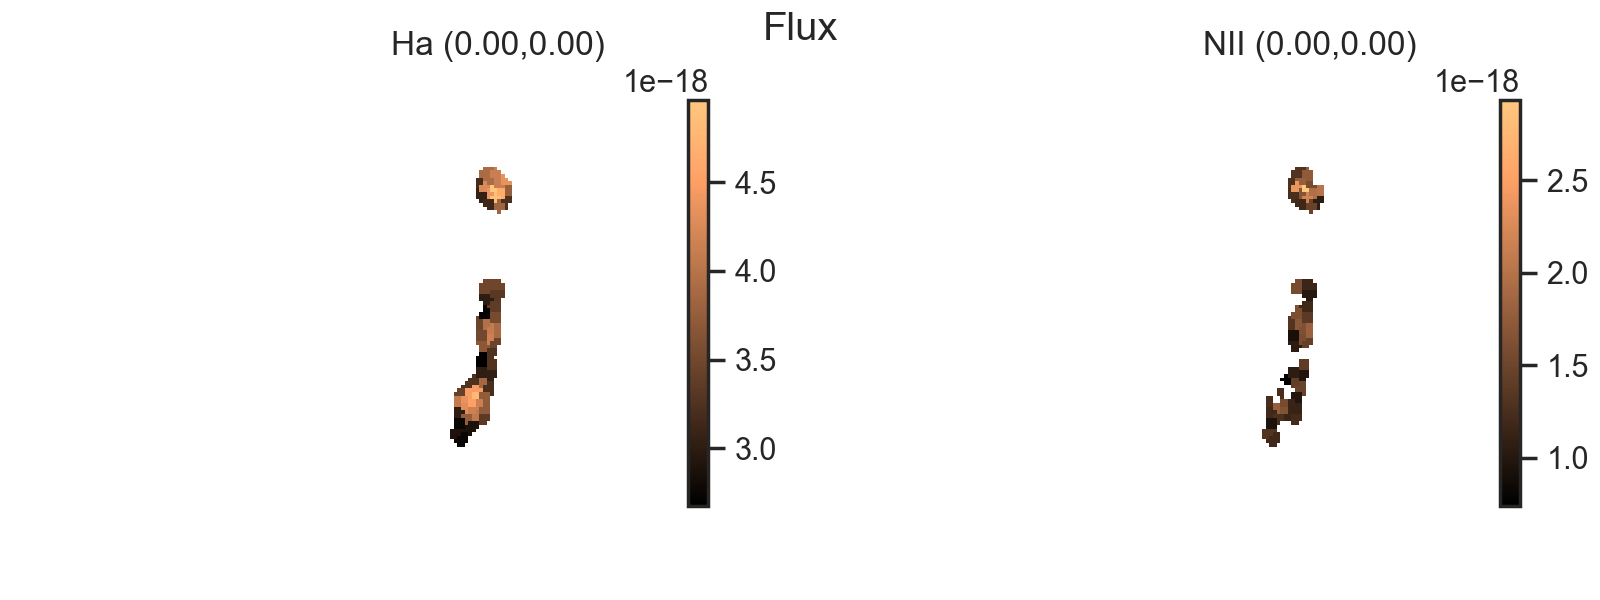

<IPython.core.display.Javascript object>


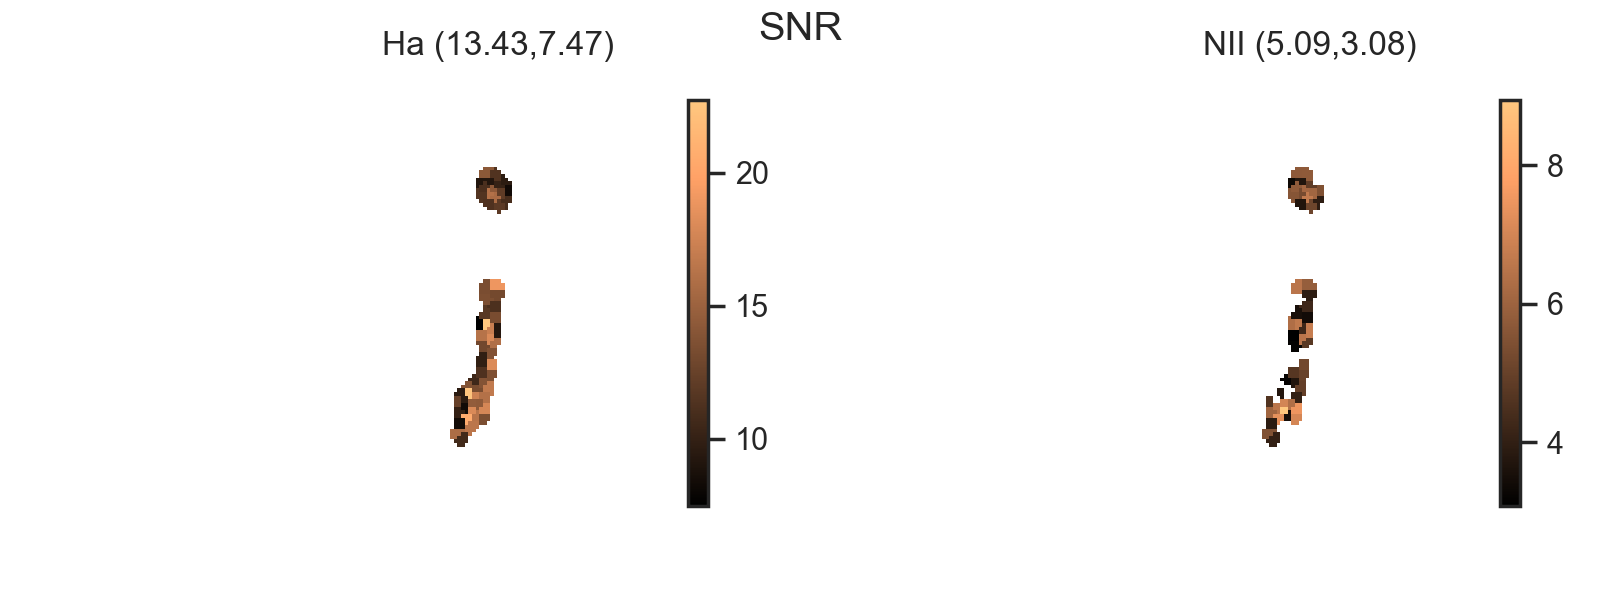

In [6]:
plot_maps(flux_maps,'Flux')
plot_maps(snr_maps,'SNR')
save_maps(flux_maps,unc_maps,'flux_SNR_10')
#save_maps(snr_maps,'snr_SNR_10')
#table.write('fluxes_bins_SNR_10.dat',format='ascii.fixed_width_two_line')
#t.show_in_notebook()  

## Plots for paper

<IPython.core.display.Javascript object>


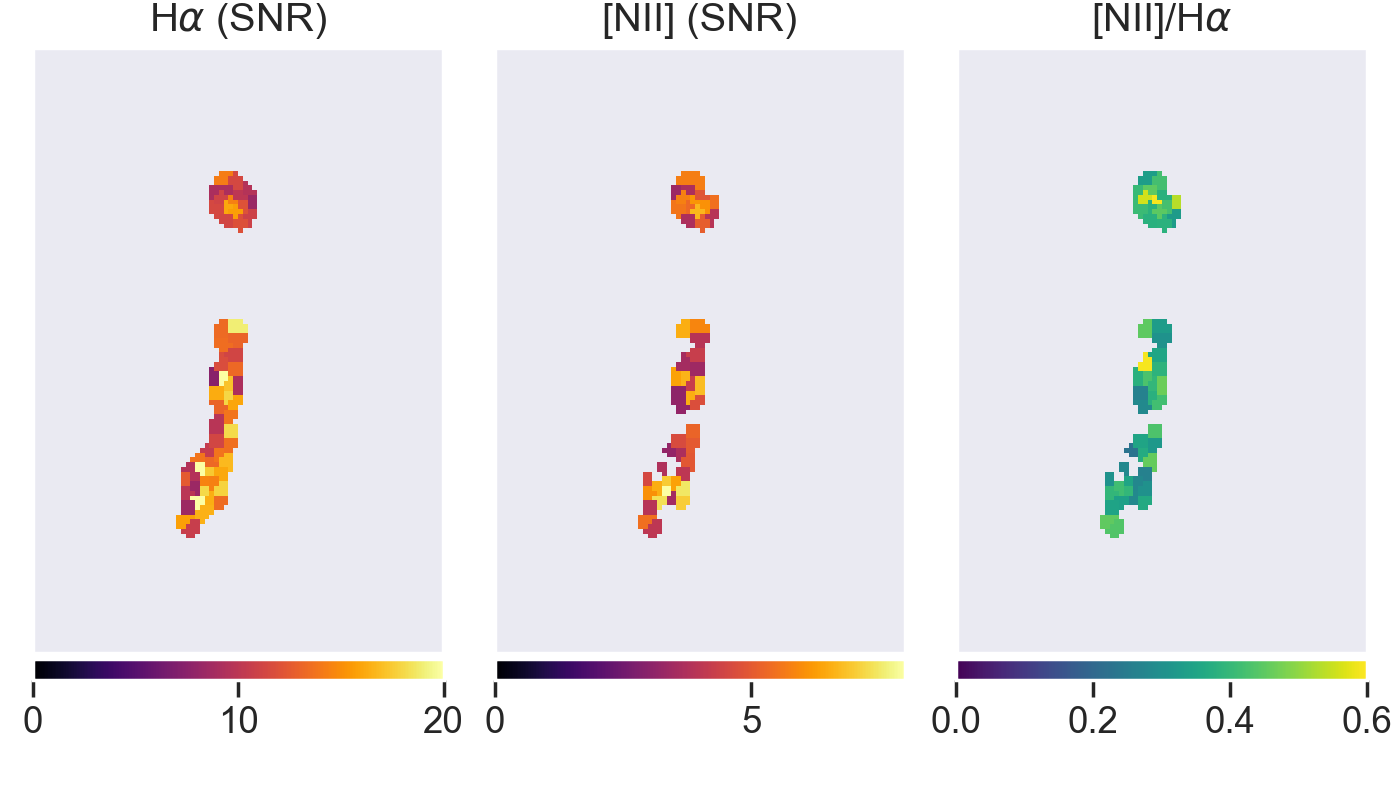

In [23]:
sns.set(font_scale=1.2)
sns.set_style('dark')
fig, ax = plt.subplots(1,3,figsize=(7,4))
fig.subplots_adjust(top=0.94,bottom=0.15,left=0.01,right=0.99,wspace=0.03)

ax[0].set_title('H$\\alpha$ (SNR)')
cax = ax[0].imshow(snr_maps[0],origin='lower',vmin=0,vmax=20,cmap='inferno')
plt.colorbar(cax,ax=ax[0],fraction=0.0325,pad=0.01,orientation='horizontal')

ax[1].set_title('[NII] (SNR)')
cax = ax[1].imshow(snr_maps[1],origin='lower',vmin=0,vmax=8,cmap='inferno')
plt.colorbar(cax,ax=ax[1],fraction=0.0325,pad=0.01,orientation='horizontal')

ax[2].set_title('[NII]/H$\\alpha$')
cax = ax[2].imshow(flux_maps[1]/flux_maps[0],origin='lower',vmin=0,vmax=0.6,cmap='viridis')
plt.colorbar(cax,ax=ax[2],fraction=0.0325,pad=0.01,orientation='horizontal')

for x in ax: x.tick_params(labelbottom=False,labelleft=False,bottom=False,left=False)

fig.savefig('../../Plots/macs1206_snr.pdf')

## 3) Calculate Metallicity

In [79]:
def prepare_array(filename):
    
    lbd, f, err, fwhm  = np.genfromtxt(filename,unpack=True,usecols=(1,2,3,5))
    lbd = list(lbd)

    cont = np.genfromtxt(filename.replace('lines','fit'),usecols=(1))
    cont_mean,_, cont_noise = sigma_clipped_stats(cont[1100:1275]) # empty of emission lines
    
    flx = []
    unc = []

    for l in[6562.77, 6583.5]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)])
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)
    
    # Put in in the correct order:
          #'[OII]3727', '[NeIII]', 'H7', 'Hd',   'Hg',   'Hb',    '[OIII]4959','[OIII]5007','Ha','[NII]6584'
    data = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, flx[0],flx[1]] 
    err  = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, unc[0],unc[1]] 

    return data, err

In [81]:
## Prepare input files
from met_and_ext_mcmc import make_obs_file

for filename in glob.glob('Alfa/Sp_bin*.fits_lines'):
    try:
        flux, uncertainties = prepare_array(filename)
        make_obs_file(flux,uncertainties,filename.replace('.fits_lines','.obs'))
    except TypeError:
        print(filename)


Alfa/Sp_bin_29.fits_lines
Alfa/Sp_bin_15.fits_lines


In [82]:
from met_and_ext_mcmc import print_ratios_ids
print_ratios_ids()

[0] OIII5007/Hb
[1] OII3727/Hb
[2] OIII5007/OII3727
[3] R23
[4] NeIII3870/OII3727
[5] NII6584/Ha
[6] OIII5007/OIII4949
[7] Hd/H7
[8] Hg/H7
[9] Hg/Hd
[10] Hb/Hd
[11] Hb/Hg
[12] Hb/H7
[13] Ha/Hg
[14] Ha/Hd
[15] Ha/H7


In [5]:
from met_and_ext_mcmc import fit_metallicity_and_extinction, calculate_SFR_from_Ha, calculate_SFR_from_OII

## Run mcmc code
met = []
ext = []
emet = []
eext = []

spectra = []
for f in glob.glob('Alfa/Sp_bin_*obs'):
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,1.0),m_range=(8.0,9.3),include=[5], # 9.2 in 12+log(O/H) is M08 limit
                                                                             extincion_law='Calzetti',nsteps=200,save=False,plot_title=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)

MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 9.12$^{+0.12}_{-0.15}$
Extinction : 0.49$^{+0.36}_{-0.35}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.67$^{+0.42}_{-0.44}$
Extinction : 0.51$^{+0.32}_{-0.33}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.92$^{+0.16}_{-0.16}$
Extinction : 0.49$^{+0.34}_{-0.34}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.67$^{+0.42}_{-0.45}$
Extinction : 0.51$^{+0.33}_{-0.36}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.65$^{+0.44}_{-0.45}$
Extinction : 0.48$^{+0.35}_{-0.32}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.87$^{+0.18}_{-0.18}$
Extinction : 0.52$^{+0.33}_{-0.36}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.97$^{+0.14}_{-0.11}$
Extinction : 0.51$^{+0.33}_{-0.33}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 9.13$^{+0.11}_{-0.12}$
Extinction : 0.49$^{+0.34}_{-0.32}$
MCMCing for 200 steps
 0.0%
49.7%
99.4%
Metallicity : 8.83$^{+0.17}_{-0.21}$
Extinction : 0.49$^

In [6]:
clean_file_name = [z.replace('Alfa/Sp_bin_','').replace('.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,eext),
          names=('bin','file','met','met_unc','ext','ext_unc'))
t.sort('bin')
t.write('metallicity_SNR_10.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

idx,bin,file,met,met_unc,ext,ext_unc
0,0,Alfa/Sp_bin_0.obs,8.67406925488,0.432387322361,0.508232320753,0.329404985716
1,1,Alfa/Sp_bin_1.obs,8.92205236003,0.157187712162,0.489723707141,0.337844414995
2,10,Alfa/Sp_bin_10.obs,9.12759047965,0.123631480876,0.532018951654,0.341152888912
3,11,Alfa/Sp_bin_11.obs,8.82637241509,0.190379242956,0.491015652043,0.331130104491
4,12,Alfa/Sp_bin_12.obs,9.05105580259,0.13266138364,0.498527187908,0.340703879373
5,13,Alfa/Sp_bin_13.obs,9.09002003644,0.151224234345,0.524149903277,0.332342402379
6,14,Alfa/Sp_bin_14.obs,8.86547366852,0.180202084692,0.518451120304,0.341263833069
7,16,Alfa/Sp_bin_16.obs,8.66964804901,0.438256724774,0.514418094327,0.345970541089
8,17,Alfa/Sp_bin_17.obs,9.11925201238,0.13353331099,0.487428261767,0.352308856551
9,18,Alfa/Sp_bin_18.obs,8.99275130355,0.150176803691,0.494570579933,0.333760110912


In [105]:
t = Table.read('metallicity_SNR_10.dat',format='ascii.fixed_width_two_line')

met_map = empty_array(mask)
met_unc_map = empty_array(mask)
ext_map = empty_array(mask)
ext_unc_map = empty_array(mask)

for d in t:
    sp_header = fits.getheader('Spectra/Sp_bin_'+str(d['bin'])+'.fits')
    bin_nb = sp_header['bin_nb']
    pix = np.where(vor_map==bin_nb)
    met_map[pix]  = d['met']
    met_unc_map[pix] = d['met_unc']
    ext_map[pix]  = d['ext']
    ext_unc_map[pix] = d['ext_unc']

header = fits.getheader('../../Data/Images/MACS1206/MACS1206_aligned_wcs.fits')
fits.writeto('Maps/Map_metallicity.fits',met_map,header=header,overwrite='True')
fits.writeto('Maps/Map_metallicity_unc.fits',met_unc_map,header=header,overwrite='True')
fits.writeto('Maps/Map_extinction.fits',ext_map,header=header,overwrite='True')
fits.writeto('Maps/Map_extinction_unc.fits',ext_unc_map,header=header,overwrite='True')

<IPython.core.display.Javascript object>


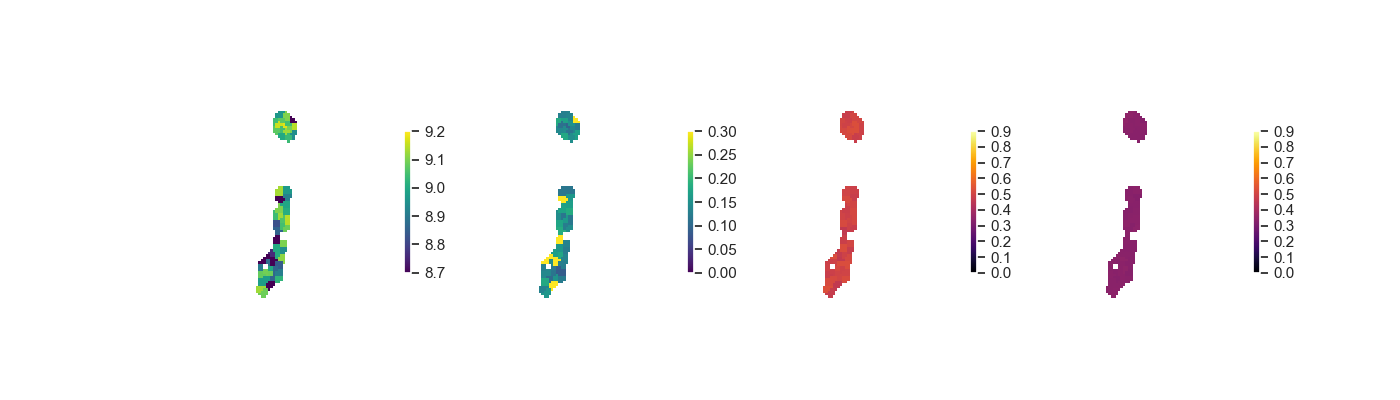

In [106]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(1,4, figsize=(14,4))
ax = ax.ravel()

cax0 = ax[0].imshow(met_map,origin='lower',vmin=8.7,vmax=9.2,cmap='viridis')
plt.colorbar(cax0,ax=ax[0],fraction=0.03)
cax1 = ax[1].imshow(met_unc_map,origin='lower',vmin=0,vmax=0.3,cmap='viridis')
plt.colorbar(cax1,ax=ax[1],fraction=0.03)
cax2 = ax[2].imshow(ext_map,origin='lower',vmin=0,vmax=0.9,cmap='inferno')
plt.colorbar(cax2,ax=ax[2],fraction=0.03)
cax3 = ax[3].imshow(ext_unc_map,origin='lower',vmin=0,vmax=0.9,cmap='inferno')
plt.colorbar(cax3,ax=ax[3],fraction=0.03)

dummy = [x.axis('off') for x in ax]

## Plots

In [6]:
cmap_met = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)

<IPython.core.display.Javascript object>


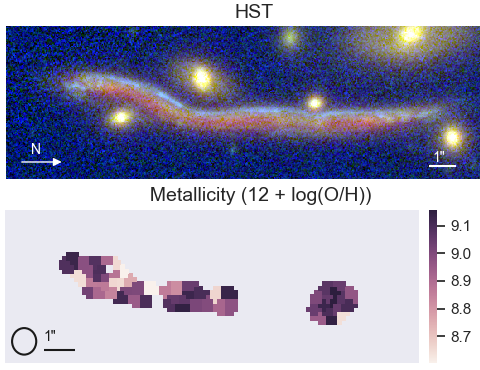

In [9]:
# Set plots
fig, ax = plt.subplots(2,1, figsize=(4.8,3.7),gridspec_kw={'height_ratios':[1,1]})
fig.subplots_adjust(left=0.01,right=1.05,hspace=0.20,top=0.93,bottom=0.02)
ax = ax.ravel()

# Plot MUSE data
ax[1].set_title('                  Metallicity (12 + log(O/H))',fontsize=14)
met_map = fits.getdata('Maps/Map_metallicity.fits')[10:-10,20:-30]
sns.heatmap(np.rot90(met_map), cmap=cmap_met, ax=ax[1],robust=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
ax[1].invert_yaxis()

#Plot HST RGB data
ax[0].set_title('HST',fontsize=14)
hst = fits.getdata('../../RGB/MACS1206_arc_RGB_160_814_435.fits')[:,25:-30]
hst_header = fits.getheader('../../Data/HST/MACS1206_arc_F435w.fits')
ax[0].imshow(np.rot90(hst),origin='lower')
ax[0].axis('off')

# Countours to guide the eye
'''dist_map_hst  =  reproject_interp('../../Data/Lensing/MACS1206/simul_MACS1206_distance_kpc_source_plane.fits', hst_header)[0][10:-10,25:-30]
bad_pix = np.where(dist_map_hst==0)
for p,q in zip(bad_pix[0],bad_pix[1]):
    dist_map_hst[p-4:p+4,q-4:q+4] = np.nan
d = ax[0].contour(np.rot90(dist_map_hst),levels=[1,5,10],colors='red',linewidths=1.3,alpha=0.7)
ax[0].clabel(d, fontsize=11, inline=1,fmt='%d')
d = ax[1].contour(np.rot90(dist_map[10:-10,20:-30]),levels=[1,5,10],colors='0.3',linewidths=0.95)
ax[1].clabel(d, fontsize=11, inline=1,fmt='%d')
'''
# North East
ax[0].annotate('',xy=(15, 20),xytext=(70, 20), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w')
ax[0].annotate('N',xy=(30, 30), color='w',fontsize=10)

# Arcsec
#HST : 8.3333333333333E-06 deg per pix also for MACS1206
ax[0].hlines(y=15,xmin=510,xmax=510+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(515, 20), color='w',fontsize=10)

ax[1].hlines(y=3,xmin=10,xmax=10+(1/0.125),color='k')
ax[1].annotate('1"',xy=(10, 5), color='k',fontsize=10)

# PSF
psf = plt.Circle((5, 5), 0.78/0.125/2, color='k',fill=False,linewidth=1.5)
ax[1].add_artist(psf)

plt.savefig('../../Plots/MACS1206_met_map_image_plane.pdf')

### Aligned

<IPython.core.display.Javascript object>


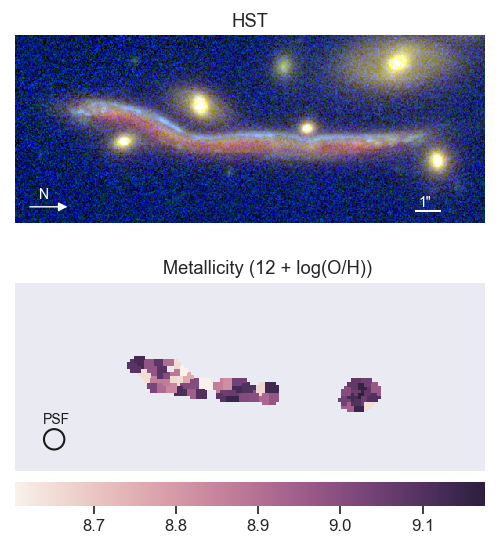

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [63]:
# Set plots
fig, ax = plt.subplots(2,1, figsize=(5.0,5.5))
fig.subplots_adjust(top=0.98,bottom=0.08,hspace=0.1,right=0.97,left=0.03)
ax = ax.ravel()

sns.set(font_scale=1.1)

# Plot MUSE data
ax[1].set_title('       Metallicity (12 + log(O/H))')
met_map,_ = reproject_interp('Maps/Map_metallicity.fits',fits.getheader('../../Data/HST/MACS1206_arc_F435w.fits'),order=0)
sns.heatmap(np.rot90(met_map), cmap=cmap_met, ax=ax[1],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.05,'orientation':'horizontal','fraction':0.1})
ax[1].invert_yaxis()

#Plot HST RGB data
ax[0].set_title('HST')
hst = fits.getdata('../../RGB/MACS1206_arc_RGB_160_814_435.fits')
hst_header = fits.getheader('../../Data/HST/MACS1206_arc_F435w.fits')
ax[0].imshow(np.rot90(hst),origin='lower')
ax[0].axis('off')


# North East
ax[0].annotate('',xy=(15, 20),xytext=(70, 20), arrowprops=dict(facecolor='w',arrowstyle='<|-',),color='w')
ax[0].annotate('N',xy=(30, 30), color='w',fontsize=10)

# Arcsec
#HST : 8.3333333333333E-06 deg per pix also for MACS1206
ax[0].hlines(y=15,xmin=510,xmax=510+(1/(8.3333333333333E-06 *3600)),color='w')
ax[0].annotate('1"',xy=(515, 20), color='w',fontsize=10)

# PSF
psf = plt.Circle((50, 40), 0.78/(8.3333333333333E-06 *3600)/2, color='k',fill=False,linewidth=1.5)
ax[1].annotate('PSF',xy=(35, 60), color='k',fontsize=10)
ax[1].add_artist(psf)

plt.savefig('../../Plots/MACS1206_met_map_image_plane.pdf')

### Source plane

In [24]:
from astropy.cosmology import WMAP9 as cosmo

In [27]:
h = fits.getheader('../../Data/Lensing/MACS1206/SP_HST/SP_reg2_MACS1206_arc_F160w.fits')
print('arcsec per pixel',h['CDELT2']*3600)

arcsec per pixel 0.003000016978268443


In [25]:
cosmo.kpc_proper_per_arcmin(1.03).to('kpc/arcsec') 

<Quantity 8.20900692 kpc / arcsec>

In [26]:
print('kpc per pixel',cosmo.kpc_proper_per_arcmin(1.03).to('kpc/arcsec').value*(h['CDELT2']*3600))

kpc per pixel 0.024627160141007184


<IPython.core.display.Javascript object>


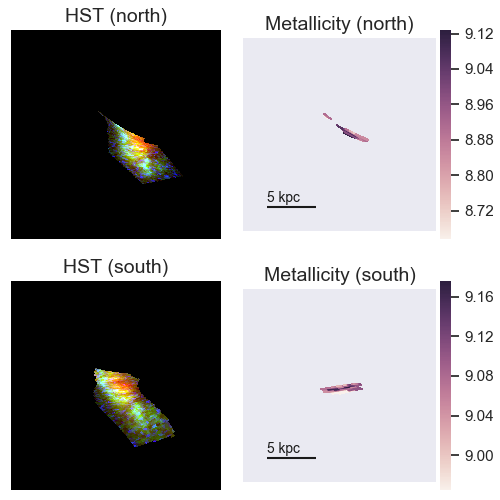

In [33]:
def crop_image(im):
    return im[200:-200,200:-200]

# Set plots
fig, ax = plt.subplots(2,2, figsize=(5,5))
fig.subplots_adjust(left=0,right=0.95,wspace=0.05,top=0.94,bottom=0.02)
ax = ax.ravel()


#Plot HST RGB data
ax[0].set_title('HST (north)',fontsize=14)
hst = fits.getdata('../../RGB/SP_MACS1206_RGB_160_814_435_reg1.fits')
hst = crop_image(hst)
ax[0].imshow(hst,origin='lower')
ax[0].axis('off')

ax[2].set_title('HST (south)',fontsize=14)
hst = fits.getdata('../../RGB/SP_MACS1206_RGB_160_814_435_reg2.fits')
hst = crop_image(hst)
ax[2].imshow(hst,origin='lower')
ax[2].axis('off')


# Plot MUSE data
ax[1].set_title('Metallicity (north)',fontsize=14)
ax[3].set_title('Metallicity (south)',fontsize=14)

hst_header = fits.getheader('../../Data/Lensing/MACS1206/SP_HST/SP_reg1_MACS1206_arc_F160w.fits')
met_map,_ = reproject_interp('../../Data/Lensing/MACS1206/SP_Map_metallicity_poly1.fits',hst_header,order=0)
met_map = crop_image(met_map)
met_map[np.where(met_map==0)] = np.nan
sns.heatmap(met_map, cmap=cmap_met, ax=ax[1],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
ax[1].invert_yaxis()

hst_header = fits.getheader('../../Data/Lensing/MACS1206/SP_HST/SP_reg2_MACS1206_arc_F160w.fits')
met_map,_ = reproject_interp('../../Data/Lensing/MACS1206/SP_Map_metallicity_poly2.fits',hst_header,order=0)
met_map = crop_image(met_map)
met_map[np.where(met_map==0)] = np.nan
sns.heatmap(met_map, cmap=cmap_met, ax=ax[3],square=True,yticklabels='',xticklabels='',cbar_kws={'pad':0.02})
ax[3].invert_yaxis()


'''#PSF
from matplotlib.patches import Ellipse
ax[1].add_artist(Ellipse(xy=(500,120), width=61.76, height=17.28, angle=np.rad2deg(1.014),edgecolor='k',facecolor='None',linewidth=2))'''
ax[1].hlines(y=100,xmin=100,xmax=100+(5/(0.0246)),color='k')
ax[1].annotate('5 kpc',xy=(100, 120), color='k',fontsize=10)
ax[3].hlines(y=100,xmin=100,xmax=100+(5/(0.0246)),color='k')
ax[3].annotate('5 kpc',xy=(100, 120), color='k',fontsize=10)

plt.savefig('../../Plots/MACS1206_met_map_source_plane.pdf')

In [ ]:
ls ../../RGB/SP_MACS1206_